# Chapter 05: Hierarchical Modeling with Partial Pooling

This notebook demonstrates one of vangja's most powerful features: **hierarchical Bayesian modeling** with partial pooling. This is inspired by the [timeseers](https://github.com/MBrouns/timeseers) library, which extends Facebook Prophet with hierarchical modeling capabilities.

## Why Hierarchical Modeling?

When forecasting multiple related time series, we often face a trade-off:

1. **Complete pooling** (`pool_type="complete"`): All series share the same parameters. This is useful when series are very similar, but ignores individual differences.

2. **No pooling** (`pool_type="individual"`): Each series has independent parameters. This captures individual differences, but doesn't leverage shared patterns and can overfit with limited data.

3. **Partial pooling** (`pool_type="partial"`): Parameters are drawn from a shared distribution (hyperprior). This allows series to "borrow strength" from each other while still capturing individual differences.

**Partial pooling is especially valuable when:**
- Some series have limited data
- Series belong to natural groups (e.g., stores in regions, products in categories)
- You want to share seasonal patterns while allowing different trends

## In This Notebook

We'll generate synthetic data representing multiple "product" time series that belong to two seasonal groups ("summer" and "winter" products), then compare:
- Individual fitting (no pooling)
- Partial pooling within groups
- Complete pooling across all series

## Setup and Imports

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from vangja import LinearTrend, FourierSeasonality
from vangja.utils import metrics

# Set random seed for reproducibility
np.random.seed(42)

print("Imports successful!")

Imports successful!


## Data Generation

We'll generate synthetic time series data representing sales for different products. The key insight is that products within the same "group" share similar seasonal patterns:

- **Summer products** (e.g., ice cream, sunscreen): Peak in summer months
- **Winter products** (e.g., hot chocolate, scarves): Peak in winter months

This scenario is ideal for hierarchical modeling: products within a group share seasonal patterns, but each product has its own trend and noise level.

In [3]:
def fourier_series(t, period, n_components):
    """Generate Fourier series basis functions."""
    x = 2 * np.pi * (np.arange(n_components) + 1) * t[:, None] / period
    return np.concatenate((np.cos(x), np.sin(x)), axis=1)


def generate_series(
    name,
    dates,
    k,  # initial slope
    m,  # initial intercept (base level)
    changepoint_times,
    delta,  # slope changes at changepoints
    yearly_beta,  # yearly seasonality coefficients
    weekly_beta,  # weekly seasonality coefficients
    noise_std,
):
    """Generate a synthetic time series with trend, seasonality, and noise.
    
    This follows the Prophet/timeseers formulation:
    y = trend + yearly_seasonality + weekly_seasonality + noise
    
    The trend is piecewise linear with changepoints.
    """
    n = len(dates)
    t = np.linspace(0, 1, n)  # Normalized time
    
    # Piecewise linear trend with changepoints
    A = (t[:, None] > changepoint_times) * 1  # Changepoint indicator matrix
    growth = k + A @ delta  # Slope at each time point
    gamma = -changepoint_times * delta  # Offset adjustment for continuity
    offset = m + A @ gamma
    trend = growth * t + offset
    
    # Yearly seasonality (using Fourier series)
    n_yearly = len(yearly_beta) // 2
    yearly_fourier = fourier_series(t, 365.25 / n, n_yearly)
    yearly_seasonality = yearly_fourier @ yearly_beta
    
    # Weekly seasonality (using Fourier series)
    n_weekly = len(weekly_beta) // 2
    weekly_fourier = fourier_series(t, 7 / n, n_weekly)
    weekly_seasonality = weekly_fourier @ weekly_beta
    
    # Combine components
    y = trend + yearly_seasonality + weekly_seasonality + np.random.randn(n) * noise_std
    
    return pd.DataFrame({"ds": dates, "y": y, "series": name})

In [4]:
# Define shared parameters for product groups
n_changepoints = 8
n_yearly_components = 3
n_weekly_components = 2

# Common date range: 3 years of daily data
dates = pd.date_range(start="2018-01-01", end="2020-12-31", freq="D")
n_days = len(dates)
t_normalized = np.linspace(0, 1, n_days)

# Shared changepoint times (evenly spaced)
changepoint_times = np.linspace(0, 0.8, n_changepoints)

# Define seasonal patterns for summer and winter product groups
# Summer products peak in summer (positive first Fourier component)
yearly_summer_beta = np.array([2.0, 0.5, 0.2, 0.8, 0.3, 0.1]) * 1000
# Winter products have opposite seasonality
yearly_winter_beta = -yearly_summer_beta

# Shared weekly pattern (slight variation by product)
weekly_base_beta = np.array([0.3, 0.1, 0.15, 0.05]) * 200

print(f"Date range: {dates.min().date()} to {dates.max().date()}")
print(f"Number of days: {n_days}")
print(f"Number of changepoints: {n_changepoints}")

Date range: 2018-01-01 to 2020-12-31
Number of days: 1096
Number of changepoints: 8


In [5]:
# Define parameters for each product
# Products in the same group share similar yearly seasonality but have individual trends

product_params = {
    # Summer products - similar yearly pattern, different trends
    "summer_1": {
        "k": 0.5,
        "m": 5000,
        "delta": np.random.laplace(0, 0.3, n_changepoints) * 2,
        "yearly_beta": yearly_summer_beta * (1.0 + np.random.randn(6) * 0.1),
        "weekly_beta": weekly_base_beta * 1.2,
        "noise_std": 150,
        "group": "summer",
    },
    "summer_2": {
        "k": 0.3,
        "m": 3000,
        "delta": np.random.laplace(0, 0.3, n_changepoints) * 1.5,
        "yearly_beta": yearly_summer_beta * (1.1 + np.random.randn(6) * 0.1),
        "weekly_beta": weekly_base_beta * 0.8,
        "noise_std": 100,
        "group": "summer",
    },
    "summer_3": {
        "k": 0.8,
        "m": 7000,
        "delta": np.random.laplace(0, 0.3, n_changepoints) * 2.5,
        "yearly_beta": yearly_summer_beta * (0.9 + np.random.randn(6) * 0.1),
        "weekly_beta": weekly_base_beta * 1.0,
        "noise_std": 200,
        "group": "summer",
    },
    # Winter products - opposite yearly pattern
    "winter_1": {
        "k": 0.4,
        "m": 4000,
        "delta": np.random.laplace(0, 0.3, n_changepoints) * 1.8,
        "yearly_beta": yearly_winter_beta * (1.0 + np.random.randn(6) * 0.1),
        "weekly_beta": weekly_base_beta * 0.9,
        "noise_std": 120,
        "group": "winter",
    },
    "winter_2": {
        "k": 0.6,
        "m": 6000,
        "delta": np.random.laplace(0, 0.3, n_changepoints) * 2.2,
        "yearly_beta": yearly_winter_beta * (0.95 + np.random.randn(6) * 0.1),
        "weekly_beta": weekly_base_beta * 1.1,
        "noise_std": 180,
        "group": "winter",
    },
}

print(f"Number of products: {len(product_params)}")
print(f"Summer products: {[k for k, v in product_params.items() if v['group'] == 'summer']}")
print(f"Winter products: {[k for k, v in product_params.items() if v['group'] == 'winter']}")

Number of products: 5
Summer products: ['summer_1', 'summer_2', 'summer_3']
Winter products: ['winter_1', 'winter_2']


In [6]:
# Generate all series
all_series = []

for name, params in product_params.items():
    series = generate_series(
        name=name,
        dates=dates,
        k=params["k"],
        m=params["m"],
        changepoint_times=changepoint_times,
        delta=params["delta"],
        yearly_beta=params["yearly_beta"],
        weekly_beta=params["weekly_beta"],
        noise_std=params["noise_std"],
    )
    all_series.append(series)
    print(f"{name}: y range = [{series['y'].min():.0f}, {series['y'].max():.0f}]")

# Combine all series
df = pd.concat(all_series, ignore_index=True)
print(f"\nTotal data points: {len(df)}")

summer_1: y range = [2534, 8614]
summer_2: y range = [493, 6705]
summer_3: y range = [5240, 9987]
winter_1: y range = [644, 6187]
winter_2: y range = [2958, 8062]

Total data points: 5480


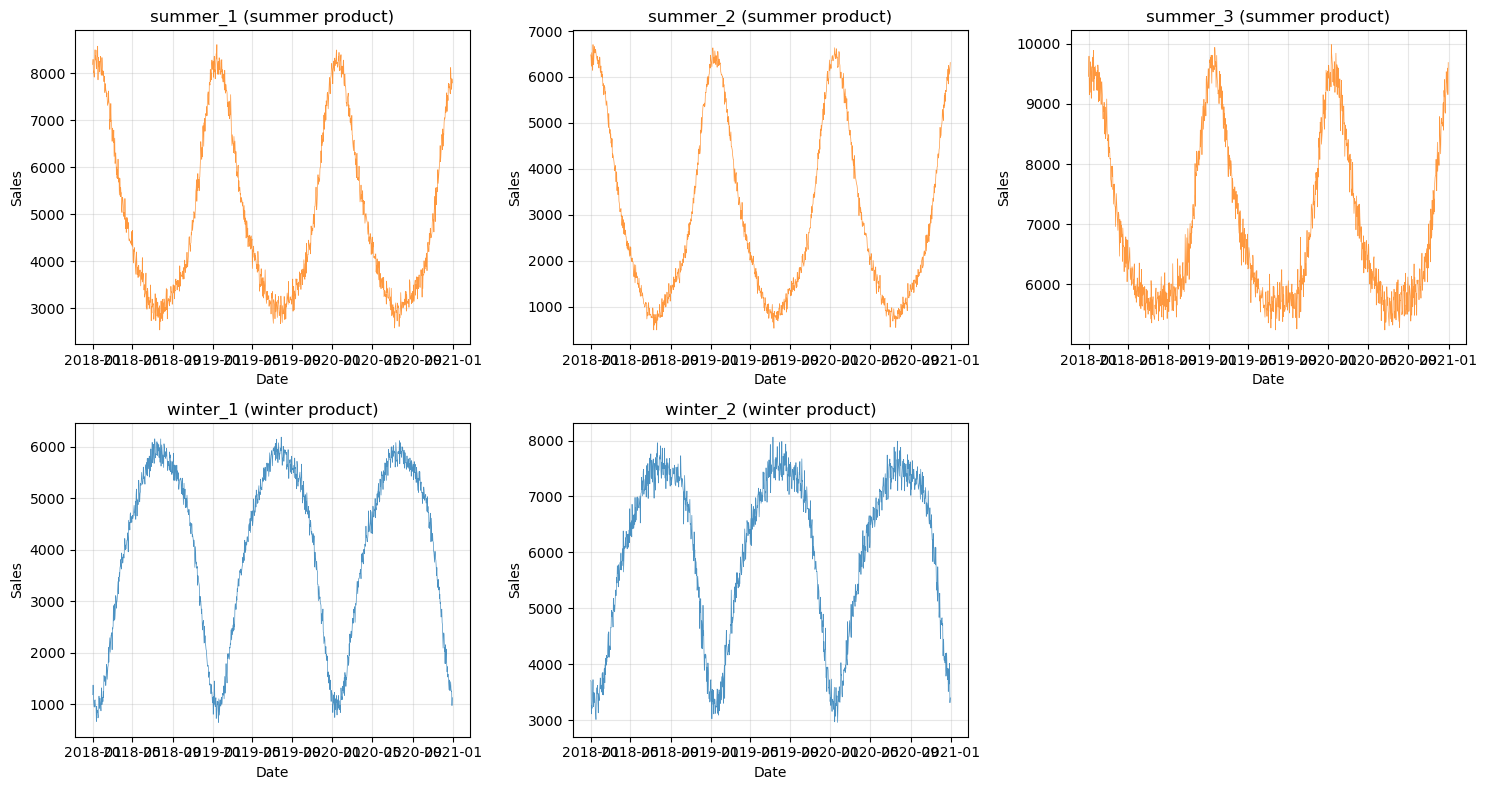

In [7]:
# Visualize all series
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, (name, params) in enumerate(product_params.items()):
    ax = axes[i]
    series_data = df[df["series"] == name]
    color = "tab:orange" if params["group"] == "summer" else "tab:blue"
    ax.plot(series_data["ds"], series_data["y"], linewidth=0.5, alpha=0.8, color=color)
    ax.set_title(f"{name} ({params['group']} product)")
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    ax.grid(True, alpha=0.3)

# Hide the 6th subplot
axes[5].axis("off")

plt.tight_layout()
plt.show()

## Train/Test Split

We'll hold out the last 90 days for testing.

In [8]:
test_days = 90
cutoff_date = dates[-test_days]

train_df = df[df["ds"] < cutoff_date].copy()
test_df = df[df["ds"] >= cutoff_date].copy()

print(f"Training period: {train_df['ds'].min().date()} to {train_df['ds'].max().date()}")
print(f"Test period: {test_df['ds'].min().date()} to {test_df['ds'].max().date()}")
print(f"Training samples: {len(train_df)} ({len(train_df) // len(product_params)} per series)")
print(f"Test samples: {len(test_df)} ({len(test_df) // len(product_params)} per series)")

Training period: 2018-01-01 to 2020-10-02
Test period: 2020-10-03 to 2020-12-31
Training samples: 5030 (1006 per series)
Test samples: 450 (90 per series)


---

## Approach 1: Individual Fitting (No Pooling)

First, let's fit each series completely independently using `pool_type="individual"`. This is equivalent to fitting separate models for each series, but done simultaneously for efficiency.

In [9]:
# Create model with individual pooling (no information sharing)
model_individual = (
    LinearTrend(n_changepoints=10, pool_type="individual")
    + FourierSeasonality(period=365.25, series_order=5, pool_type="individual")
    + FourierSeasonality(period=7, series_order=2, pool_type="individual")
)

print(f"Model: {model_individual}")

Model: LT(n=10,r=0.8,tm=None) + FS(p=365.25,n=5,tm=None) + FS(p=7,n=2,tm=None)


In [10]:
# Fit the individual model
start_time = time.time()
model_individual.fit(train_df, method="mapx", scale_mode="individual")
time_individual = time.time() - start_time

print(f"Individual fitting time: {time_individual:.2f}s")
print(f"Group mapping: {model_individual.groups_}")

Output()

Individual fitting time: 4.85s
Group mapping: {0: 'summer_1', 1: 'summer_2', 2: 'summer_3', 3: 'winter_1', 4: 'winter_2'}


In [11]:
# Generate predictions
future_individual = model_individual.predict(horizon=test_days, freq="D")

# Calculate metrics for each series
individual_metrics = []
for name in product_params.keys():
    group_code = [k for k, v in model_individual.groups_.items() if v == name][0]
    test_series = test_df[test_df["series"] == name]
    future_for_metrics = future_individual[["ds", f"yhat_{group_code}"]].copy()
    future_for_metrics.columns = ["ds", "yhat_0"]
    m = metrics(test_series, future_for_metrics, "complete")
    m.index = [name]
    individual_metrics.append(m)

individual_metrics_df = pd.concat(individual_metrics)
print("Individual Fitting Metrics:")
display(individual_metrics_df)

Individual Fitting Metrics:


,mse,rmse,mae,mape
summer_1,23686.762552,153.905044,121.495452,0.021963
summer_2,11436.614975,106.942110,84.178492,0.024784
summer_3,45346.976472,212.948295,176.546292,0.024021
winter_1,14931.007397,122.192501,99.503195,0.038552
winter_2,34434.931962,185.566516,142.138651,0.026965


---

## Approach 2: Partial Pooling (Hierarchical)

Now let's use partial pooling with `pool_type="partial"`. In this approach:

- **Trend**: Each series has its own slope and intercept, but they're drawn from a shared distribution. This allows series to "borrow strength" from each other.
- **Seasonality**: The Fourier coefficients are partially pooled, allowing series to share seasonal patterns while still having individual variations.

The hierarchical structure is:
```
slope_shared ~ Normal(0, σ_slope)
slope[i] ~ Normal(slope_shared, σ_individual)
```

This is the key advantage of vangja over Prophet: the ability to learn shared patterns across multiple time series while respecting individual differences.

In [12]:
# Create model with partial pooling (hierarchical)
model_partial = (
    LinearTrend(n_changepoints=10, pool_type="partial", shrinkage_strength=10)
    + FourierSeasonality(period=365.25, series_order=5, pool_type="partial", shrinkage_strength=10)
    + FourierSeasonality(period=7, series_order=2, pool_type="partial", shrinkage_strength=10)
)

print(f"Model: {model_partial}")

Model: LT(n=10,r=0.8,tm=None) + FS(p=365.25,n=5,tm=None) + FS(p=7,n=2,tm=None)


In [13]:
# Fit the partial pooling model
start_time = time.time()
model_partial.fit(train_df, method="mapx", scale_mode="individual")
time_partial = time.time() - start_time

print(f"Partial pooling fitting time: {time_partial:.2f}s")
print(f"Group mapping: {model_partial.groups_}")

Output()

Partial pooling fitting time: 1.99s
Group mapping: {0: 'summer_1', 1: 'summer_2', 2: 'summer_3', 3: 'winter_1', 4: 'winter_2'}


In [14]:
# Generate predictions
future_partial = model_partial.predict(horizon=test_days, freq="D")

# Calculate metrics for each series
partial_metrics = []
for name in product_params.keys():
    group_code = [k for k, v in model_partial.groups_.items() if v == name][0]
    test_series = test_df[test_df["series"] == name]
    future_for_metrics = future_partial[["ds", f"yhat_{group_code}"]].copy()
    future_for_metrics.columns = ["ds", "yhat_0"]
    m = metrics(test_series, future_for_metrics, "complete")
    m.index = [name]
    partial_metrics.append(m)

partial_metrics_df = pd.concat(partial_metrics)
print("Partial Pooling Metrics:")
display(partial_metrics_df)

Partial Pooling Metrics:


,mse,rmse,mae,mape
summer_1,24746.739034,157.310963,124.677478,0.022441
summer_2,11444.328220,106.978167,84.244444,0.024832
summer_3,48036.518849,219.172350,185.582994,0.024945
winter_1,16047.843301,126.680082,100.140340,0.040437
winter_2,30778.779650,175.438820,138.159994,0.026463


---

## Approach 3: Complete Pooling

For comparison, let's also try complete pooling where all series share the same parameters. This is rarely ideal for multiple series, but useful as a baseline.

In [15]:
# Create model with complete pooling (all series share parameters)
model_complete = (
    LinearTrend(n_changepoints=10, pool_type="complete")
    + FourierSeasonality(period=365.25, series_order=5, pool_type="complete")
    + FourierSeasonality(period=7, series_order=2, pool_type="complete")
)

print(f"Model: {model_complete}")

Model: LT(n=10,r=0.8,tm=None) + FS(p=365.25,n=5,tm=None) + FS(p=7,n=2,tm=None)


In [16]:
# Fit the complete pooling model
start_time = time.time()
model_complete.fit(train_df, method="mapx")
time_complete = time.time() - start_time

print(f"Complete pooling fitting time: {time_complete:.2f}s")

Output()

Complete pooling fitting time: 1.09s


In [17]:
# Generate predictions
future_complete = model_complete.predict(horizon=test_days, freq="D")

# Calculate metrics for each series (same prediction for all)
complete_metrics = []
for name in product_params.keys():
    test_series = test_df[test_df["series"] == name]
    future_for_metrics = future_complete[["ds", "yhat_0"]].copy()
    m = metrics(test_series, future_for_metrics, "complete")
    m.index = [name]
    complete_metrics.append(m)

complete_metrics_df = pd.concat(complete_metrics)
print("Complete Pooling Metrics:")
display(complete_metrics_df)

Complete Pooling Metrics:


,mse,rmse,mae,mape
summer_1,1.539150e+06,1240.625017,1036.167229,0.169743
summer_2,2.961604e+06,1720.931186,1427.604658,0.533217
summer_3,6.101240e+06,2470.068749,2306.204418,0.296747
winter_1,6.230114e+06,2496.019624,1981.163735,1.040389
winter_2,2.455544e+06,1567.017477,1397.541718,0.259283


---

## Comparison of Approaches

Let's compare all three approaches side by side.

In [18]:
# Create comparison table
comparison_rows = []

for name in product_params.keys():
    comparison_rows.append({
        "Series": name,
        "Group": product_params[name]["group"],
        "Approach": "Individual",
        "RMSE": individual_metrics_df.loc[name, "rmse"],
        "MAE": individual_metrics_df.loc[name, "mae"],
        "MAPE": individual_metrics_df.loc[name, "mape"],
    })
    comparison_rows.append({
        "Series": name,
        "Group": product_params[name]["group"],
        "Approach": "Partial",
        "RMSE": partial_metrics_df.loc[name, "rmse"],
        "MAE": partial_metrics_df.loc[name, "mae"],
        "MAPE": partial_metrics_df.loc[name, "mape"],
    })
    comparison_rows.append({
        "Series": name,
        "Group": product_params[name]["group"],
        "Approach": "Complete",
        "RMSE": complete_metrics_df.loc[name, "rmse"],
        "MAE": complete_metrics_df.loc[name, "mae"],
        "MAPE": complete_metrics_df.loc[name, "mape"],
    })

comparison_df = pd.DataFrame(comparison_rows)
print("Full Comparison:")
display(comparison_df)

Full Comparison:


,Series,Group,Approach,RMSE,MAE,MAPE
0,summer_1,summer,Individual,153.905044,121.495452,0.021963
1,summer_1,summer,Partial,157.310963,124.677478,0.022441
2,summer_1,summer,Complete,1240.625017,1036.167229,0.169743
3,summer_2,summer,Individual,106.942110,84.178492,0.024784
4,summer_2,summer,Partial,106.978167,84.244444,0.024832
5,summer_2,summer,Complete,1720.931186,1427.604658,0.533217
6,summer_3,summer,Individual,212.948295,176.546292,0.024021
7,summer_3,summer,Partial,219.172350,185.582994,0.024945
8,summer_3,summer,Complete,2470.068749,2306.204418,0.296747
9,winter_1,winter,Individual,122.192501,99.503195,0.038552


In [19]:
# Summary statistics by approach
summary = comparison_df.groupby("Approach").agg({
    "RMSE": ["mean", "std"],
    "MAE": ["mean", "std"],
    "MAPE": ["mean", "std"],
}).round(2)

print("Summary Statistics by Approach:")
display(summary)

Summary Statistics by Approach:


RMSE              MAE          MAPE      
               mean     std     mean     std  mean   std
Approach                                                
Complete    1898.93  560.79  1629.74  507.00  0.46  0.35
Individual   156.31   43.79   124.77   36.33  0.03  0.01
Partial      157.12   43.67   126.56   39.08  0.03  0.01

In [20]:
# Timing comparison
timing_df = pd.DataFrame({
    "Approach": ["Individual", "Partial", "Complete"],
    "Time (s)": [time_individual, time_partial, time_complete],
})

print("Timing Comparison:")
display(timing_df)

Timing Comparison:


,Approach,Time (s)
0,Individual,4.850651
1,Partial,1.988140
2,Complete,1.091810


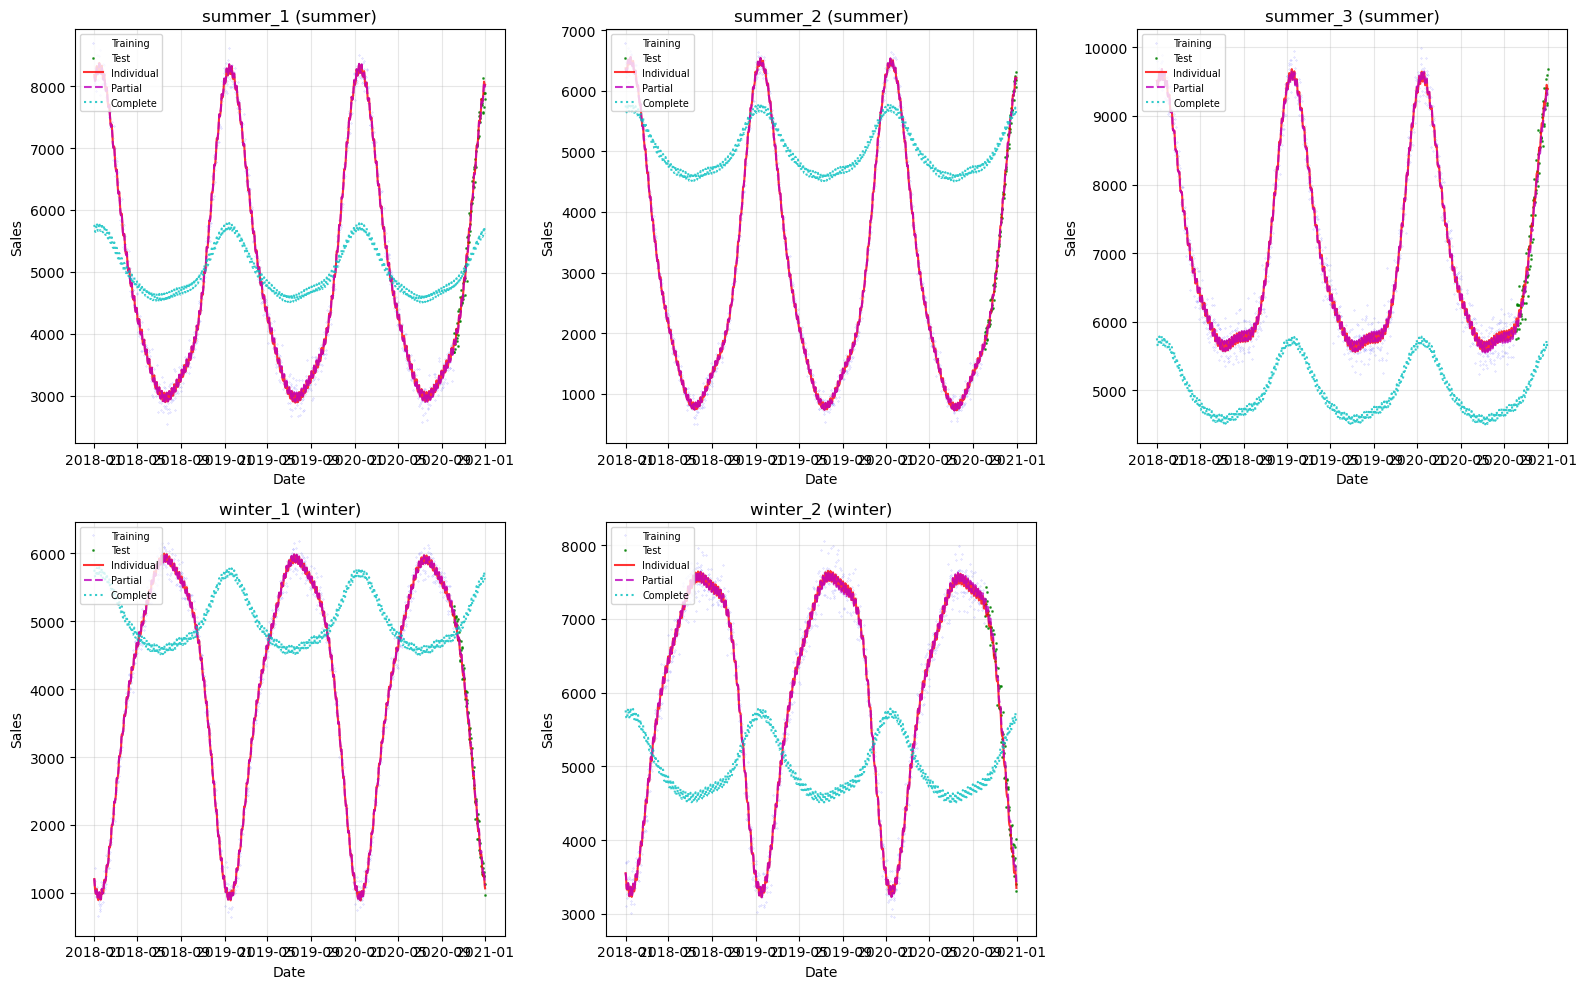

In [21]:
# Visualize predictions for each series
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, (name, params) in enumerate(product_params.items()):
    ax = axes[i]
    train_series = train_df[train_df["series"] == name]
    test_series = test_df[test_df["series"] == name]
    
    # Get predictions
    ind_group = [k for k, v in model_individual.groups_.items() if v == name][0]
    par_group = [k for k, v in model_partial.groups_.items() if v == name][0]
    
    # Plot training data
    ax.plot(train_series["ds"], train_series["y"], "b.", markersize=0.5, alpha=0.3, label="Training")
    # Plot test data
    ax.plot(test_series["ds"], test_series["y"], "g.", markersize=2, alpha=0.7, label="Test")
    # Plot predictions
    ax.plot(future_individual["ds"], future_individual[f"yhat_{ind_group}"], "r-", linewidth=1.5, alpha=0.8, label="Individual")
    ax.plot(future_partial["ds"], future_partial[f"yhat_{par_group}"], "m--", linewidth=1.5, alpha=0.8, label="Partial")
    ax.plot(future_complete["ds"], future_complete["yhat_0"], "c:", linewidth=1.5, alpha=0.8, label="Complete")
    
    ax.set_title(f"{name} ({params['group']})")
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    ax.legend(loc="upper left", fontsize=7)
    ax.grid(True, alpha=0.3)

axes[5].axis("off")
plt.tight_layout()
plt.show()

---

## Understanding Shrinkage Strength

The `shrinkage_strength` parameter controls how much the individual series are pulled toward the shared distribution:

- **High shrinkage** (e.g., 100): Series are pulled strongly toward the shared mean → closer to complete pooling
- **Low shrinkage** (e.g., 1): Series have more freedom to deviate → closer to individual fitting

Let's visualize this effect:

In [22]:
shrinkage_values = [1, 10, 50, 100]
shrinkage_results = {}

for shrinkage in shrinkage_values:
    model = (
        LinearTrend(n_changepoints=10, pool_type="partial", shrinkage_strength=shrinkage)
        + FourierSeasonality(period=365.25, series_order=5, pool_type="partial", shrinkage_strength=shrinkage)
        + FourierSeasonality(period=7, series_order=2, pool_type="partial", shrinkage_strength=shrinkage)
    )
    
    model.fit(train_df, method="mapx", scale_mode="individual")
    future = model.predict(horizon=test_days, freq="D")
    
    # Calculate average RMSE
    rmse_list = []
    for name in product_params.keys():
        group_code = [k for k, v in model.groups_.items() if v == name][0]
        test_series = test_df[test_df["series"] == name]
        future_for_metrics = future[["ds", f"yhat_{group_code}"]].copy()
        future_for_metrics.columns = ["ds", "yhat_0"]
        m = metrics(test_series, future_for_metrics, "complete")
        rmse_list.append(m["rmse"].values[0])
    
    shrinkage_results[shrinkage] = {
        "mean_rmse": np.mean(rmse_list),
        "std_rmse": np.std(rmse_list),
    }
    print(f"Shrinkage={shrinkage}: Mean RMSE = {np.mean(rmse_list):.2f} ± {np.std(rmse_list):.2f}")

Output()

Shrinkage=1: Mean RMSE = 158.74 ± 40.11


Output()

Shrinkage=10: Mean RMSE = 157.12 ± 39.06


Output()

Shrinkage=50: Mean RMSE = 157.21 ± 39.26


Output()

Shrinkage=100: Mean RMSE = 158.24 ± 39.73


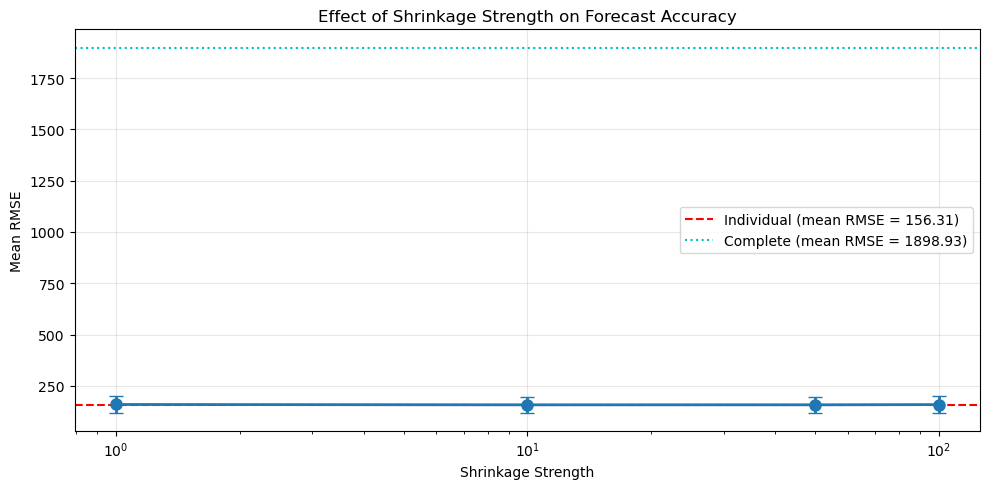

In [23]:
# Plot shrinkage effect
fig, ax = plt.subplots(figsize=(10, 5))

shrinkages = list(shrinkage_results.keys())
mean_rmses = [shrinkage_results[s]["mean_rmse"] for s in shrinkages]
std_rmses = [shrinkage_results[s]["std_rmse"] for s in shrinkages]

ax.errorbar(shrinkages, mean_rmses, yerr=std_rmses, marker="o", capsize=5, linewidth=2, markersize=8)
ax.axhline(individual_metrics_df["rmse"].mean(), color="r", linestyle="--", label=f"Individual (mean RMSE = {individual_metrics_df['rmse'].mean():.2f})")
ax.axhline(complete_metrics_df["rmse"].mean(), color="c", linestyle=":", label=f"Complete (mean RMSE = {complete_metrics_df['rmse'].mean():.2f})")

ax.set_xlabel("Shrinkage Strength")
ax.set_ylabel("Mean RMSE")
ax.set_title("Effect of Shrinkage Strength on Forecast Accuracy")
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xscale("log")

plt.tight_layout()
plt.show()

---

## Summary and Key Takeaways

### Pool Types in Vangja

| Pool Type | Description | Use Case |
|-----------|-------------|----------|
| `"complete"` | All series share parameters | Very similar series, single pattern to learn |
| `"individual"` | Each series has independent parameters | Unrelated series, sufficient data per series |
| `"partial"` | Hierarchical with shared hyperpriors | Related series, want to borrow strength |

### When to Use Partial Pooling

✅ **Use partial pooling when:**
- Series belong to natural groups (products, stores, regions)
- Some series have limited data
- You expect shared patterns across series
- You want to avoid overfitting on individual series

❌ **Avoid partial pooling when:**
- Series are truly independent with no shared patterns
- Each series has abundant data for reliable estimation
- Computational speed is critical (partial pooling adds complexity)

### Tuning Shrinkage Strength

- **Start with `shrinkage_strength=10`** as a reasonable default
- **Increase** (e.g., 50-100) if you want more information sharing
- **Decrease** (e.g., 1-5) if series are quite different
- Use cross-validation to find the optimal value for your data
```